Add imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import scipy
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from ast import literal_eval
from tensorflow.keras import layers
from tensorflow.keras.applications import inception_v3

Setup gpu

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-05-25 20:49:28.596936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 20:49:28.626783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 20:49:28.626949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 20:49:28.679708: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Set paths to data

In [3]:
TRAIN_CSV = '../data/train.csv'
TRAIN_IMAGES_DIR = '../data/train_images/'

Load csv using pandas

In [4]:
traindf = pd.read_csv(TRAIN_CSV, dtype=str)
traindf['labels'] = traindf['labels'].str.split()
traindf
traindf['labels'].value_counts()

[scab]                                 4826
[healthy]                              4624
[frog_eye_leaf_spot]                   3181
[rust]                                 1860
[complex]                              1602
[powdery_mildew]                       1184
[scab, frog_eye_leaf_spot]              686
[scab, frog_eye_leaf_spot, complex]     200
[frog_eye_leaf_spot, complex]           165
[rust, frog_eye_leaf_spot]              120
[rust, complex]                          97
[powdery_mildew, complex]                87
Name: labels, dtype: int64

In [5]:
traindf

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
18627,fffb900a92289a33.jpg,[healthy]
18628,fffc488fa4c0e80c.jpg,[scab]
18629,fffc94e092a59086.jpg,[rust]
18630,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


Load images using ImageDataGenerator, copied from [StackOverflow](https://stackoverflow.com/questions/59464409/loading-images-in-keras-for-cnn-from-directory-but-label-in-csv-file)

In [6]:
shape = (224, 224, 3)
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255., validation_split=0.2)
train_generator = datagen.flow_from_dataframe(dataframe = traindf,
                                              directory = TRAIN_IMAGES_DIR,
                                              featurewise_std_normalization = True,
                                              x_col = 'image',
                                              y_col = 'labels',
                                              subset = 'training',
                                              batch_size = 32,
                                              seed = 1,
                                              shuffle = True,
                                              class_mode = 'categorical',
                                              target_size = shape[:2]
                                             )

validation_generator = datagen.flow_from_dataframe(dataframe = traindf,
                                              directory = TRAIN_IMAGES_DIR,
                                              featurewise_std_normalization = True,
                                              x_col = 'image',
                                              y_col = 'labels',
                                              subset = 'validation',
                                              batch_size = 32,
                                              seed = 1,
                                              shuffle = True,
                                              class_mode = 'categorical',
                                              target_size = shape[:2]
                                             )

Found 14906 validated image filenames belonging to 6 classes.
Found 3726 validated image filenames belonging to 6 classes.


In [7]:
train_images, train_labels = next(iter(train_generator))
val_images, val_labels = next(iter(validation_generator))

In [8]:
classes_amount = 6

### Third model:

In [9]:
intercept_layer = inception_v3.InceptionV3(weights ='imagenet', include_top = False)
for layer in intercept_layer.layers:
    layer.trainable = False

imput_layer = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=shape),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])
    
model2 = keras.Sequential([
    imput_layer,
    intercept_layer,
    layers.GlobalAveragePooling2D(),
    layers.Dense(classes_amount, kernel_initializer = 'uniform', activation = "softmax")
])

model2.compile(loss = 'categorical_crossentropy',
               optimizer = 'Adam',
               metrics = ['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 21,815,078
Trainable params: 12,294
Non-trainable params: 21,802,784
_________________________________________________________________


In [10]:
history2 = model2.fit(train_generator, 
                     epochs = 5,
                    validation_data = validation_generator,
                     verbose = 1)

model2.save(f"model/m2.5")

Epoch 1/5


2022-05-25 20:49:46.894796: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-05-25 20:49:47.401227: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


  1/466 [..............................] - ETA: 1:05:40 - loss: 2.1782 - accuracy: 0.1250

2022-05-25 20:49:48.569165: W tensorflow/core/common_runtime/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


466/466 [==============================] - 1728s 4s/step - loss: 1.3131 - accuracy: 0.5475 - val_loss: 1.1740 - val_accuracy: 0.5888
Epoch 2/5
466/466 [==============================] - 1701s 4s/step - loss: 1.1423 - accuracy: 0.6200 - val_loss: 1.0373 - val_accuracy: 0.6559
Epoch 3/5
466/466 [==============================] - 1689s 4s/step - loss: 1.1168 - accuracy: 0.6329 - val_loss: 1.3044 - val_accuracy: 0.5368
Epoch 4/5
466/466 [==============================] - 1701s 4s/step - loss: 1.0824 - accuracy: 0.6466 - val_loss: 1.0392 - val_accuracy: 0.6498
Epoch 5/5
466/466 [==============================] - 1656s 4s/step - loss: 1.0834 - accuracy: 0.6460 - val_loss: 1.0585 - val_accuracy: 0.6428


INFO:tensorflow:Assets written to: model/m2.5/assets


INFO:tensorflow:Assets written to: model/m2.5/assets


In [11]:
print("Evaluate")

result = model2.evaluate(validation_generator)
dict(zip(model2.metrics_names, result))

Evaluate
117/117 [==============================] - 326s 3s/step - loss: 1.0585 - accuracy: 0.6428


{'loss': 1.058523178100586, 'accuracy': 0.6427804827690125}

1/1 [==============================] - 1s 1s/step


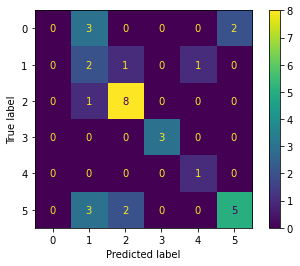

In [12]:
model_predictions2 = model2.predict(val_images)

y_true = [np.argmax(row) for row in val_labels]
y_pred2 = [np.argmax(row) for row in model_predictions2]

matrix = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred2))

matrix.plot()